In [1]:
%load_ext autoreload
%autoreload 2

In [20]:
import numpy as np
from IPython.display import display # type: ignore
import polars as pl
import matplotlib.pyplot as plt # type: ignore
from raphtory import Graph
from raphtory import algorithms as algo
from typing import List, Tuple
from pathlib import Path
import networkx as nx
import os
import torch
from torch import Tensor
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import coalesce
from torch_sparse import SparseTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

In [86]:
#l2g related imports
from l2gv2.patch.clustering import metis_clustering
from l2gv2.graphs import TGraph, induced_subgraph
from l2gv2.patch.patches import create_patch_data
from l2gv2.datasets import get_dataset
from l2gv2.embedding.gae import VGAE, GAE
from l2gv2.embedding.train import train
from l2gv2.embedding.gae.utils.loss import VGAE_loss, GAE_loss
from l2gv2.patch.patches import Patch
from l2gv2.align import get_aligner

# <font color="grey"> Graph Clustering and Patch Embeddings</font>

###  <a id='chapter1'> <font color="grey">1. The local2global approach </font></a>

The initial step in creating the patch graph consists of clustering the graph. The clusters 

The Cora dataset is a well-known dataset in the field of graph research. This consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [4]:
dataset = get_dataset("Cora")
coral = dataset[0]

2025-03-26 13:35:09,640 - INFO - NumExpr defaulting to 8 threads.


Loading edge and node data from memory


In [5]:
# For the time being, use TGraph. Eventually, switch to Raphtory
tgraph = TGraph(coral.edge_index)

In [6]:
num_clusters=9
cluster_tensor = metis_clustering(tgraph, num_clusters=num_clusters)
cluster_tensor

tensor([7, 0, 5,  ..., 5, 2, 3])

In [ ]:
# Visualize
G = to_networkx(coral, to_undirected=True)
node_colors = [cluster_tensor[node].item() for node in G.nodes()]
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=0.5, nodelist=list(cent.keys()), cmap=plt.get_cmap('plasma'))
edges = nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.title('Cluster Visualization')
plt.axis('off')
plt.show()

In [11]:
# Compute unique clusters and their counts
unique_clusters, counts = torch.unique(cluster_tensor, return_counts=True)
cluster_counts = dict(zip(unique_clusters.tolist(), counts.tolist()))
print(cluster_counts)

{0: 289, 1: 295, 2: 296, 3: 304, 4: 295, 5: 303, 6: 301, 7: 309, 8: 316}


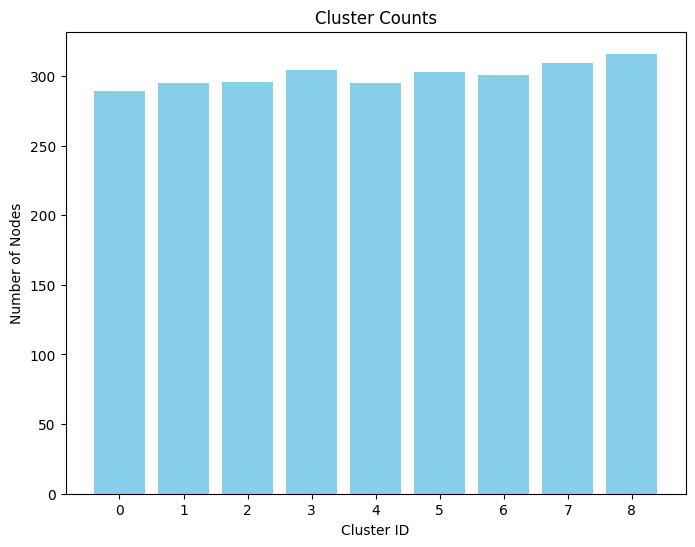

In [12]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
plt.bar(unique_clusters, counts, color='skyblue')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Nodes')
plt.title('Cluster Counts')
plt.xticks(unique_clusters)
plt.show()

In [21]:
nodes = torch.concat((coral.edge_index[0,:],coral.edge_index[1,:])).unique()
coral.nodes = nodes
coral.adj_t = SparseTensor(row=coral.edge_index[0], col=coral.edge_index[1], sparse_sizes=(coral.num_nodes, coral.num_nodes))
coral.adj_t = coral.adj_t.to_symmetric()  
coral = TGraph(edge_index=coral.edge_index,  num_nodes=coral.num_nodes, x=coral.x, ensure_sorted=True, undir=False)

In [23]:
pt, pgraph = create_patch_data(
    coral, 
    partition_tensor=cluster_tensor,
    min_overlap=10, 
    target_overlap=20, 
    verbose=True)
patch_data = [induced_subgraph(coral, p) for p in pt]

number of patches: 9
average patch degree: 3.7777777777777777


enlarging patch overlaps:   0%|          | 0/9 [00:00<?, ?it/s]

Finding overlaps between patches...
Total number of nodes appearing in multiple patches: 318

Sample patch overlaps:
Overlap between patch 0 and patch 1: 22 nodes
Overlap between patch 0 and patch 2: 1 nodes
Overlap between patch 0 and patch 3: 21 nodes
Overlap between patch 1 and patch 2: 10 nodes
Overlap between patch 1 and patch 3: 11 nodes
Overlap between patch 1 and patch 4: 20 nodes
Overlap between patch 2 and patch 3: 0 nodes
Overlap between patch 2 and patch 4: 0 nodes
Overlap between patch 2 and patch 5: 20 nodes


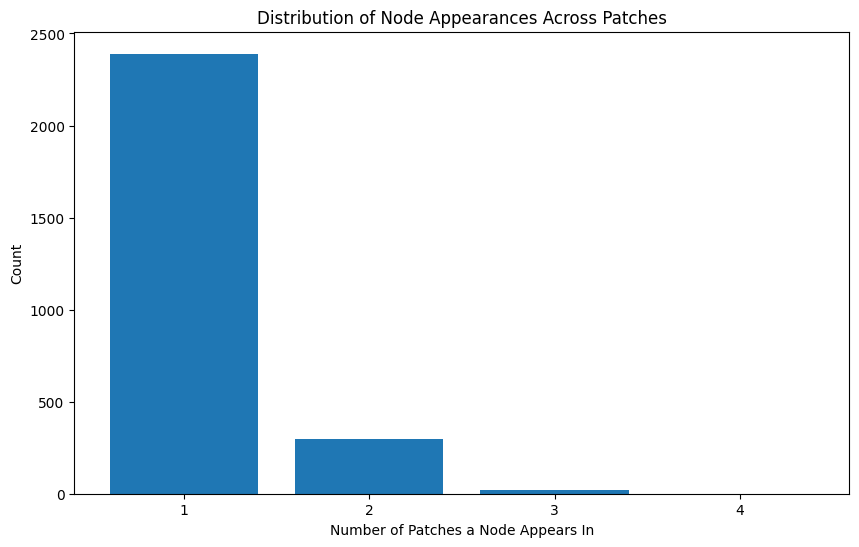

In [28]:
# Find overlaps between patches
print("Finding overlaps between patches...")

# Create a dictionary to track which nodes appear in which patches
node_to_patches = {}

# Populate the dictionary
for i, patch in enumerate(patch_data):
    for node in patch.nodes:
        if node.item() not in node_to_patches:
            node_to_patches[node.item()] = []
        node_to_patches[node.item()].append(i)

# Find nodes that appear in multiple patches
overlap_nodes = {node: patches for node, patches in node_to_patches.items() if len(patches) > 1}

# Print some statistics
total_overlap_nodes = len(overlap_nodes)
print(f"Total number of nodes appearing in multiple patches: {total_overlap_nodes}")

# Calculate overlap between specific patch pairs
if len(patch_data) > 1:
    print("\nSample patch overlaps:")
    for i in range(min(3, len(patch_data))):
        for j in range(i+1, min(i+4, len(patch_data))):
            # Convert to sets for efficient intersection
            nodes_i = set(patch_data[i].nodes.cpu().numpy())
            nodes_j = set(patch_data[j].nodes.cpu().numpy())
            overlap = nodes_i.intersection(nodes_j)
            print(f"Overlap between patch {i} and patch {j}: {len(overlap)} nodes")

# Visualize the distribution of node appearances across patches
appearances = [len(patches) for patches in node_to_patches.values()]
unique_appearances, counts = np.unique(appearances, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_appearances, counts)
plt.xlabel('Number of Patches a Node Appears In')
plt.ylabel('Count')
plt.title('Distribution of Node Appearances Across Patches')
plt.xticks(unique_appearances)
plt.show()


In [40]:
for p in patch_data:
    p.x=coral.x[p.nodes]
    p.num_nodes=p.nodes.size()[0]
    p.adj_t = SparseTensor(row=p.edge_index[0], col=p.edge_index[1], sparse_sizes=(p.num_nodes, p.num_nodes))
    p.adj_t = p.adj_t.to_symmetric() 

In [88]:
patches = []
for p in patch_data:
    model = GAE(dim=2, hidden_dim=128, num_features=p.x.shape[1]).to(device)
    model = train(p, model, loss_fun=GAE_loss, num_epochs=200, verbose=False, lr=0.001)
    with torch.no_grad():
        model.eval()
        coordinates = model.encode(p).to("cpu").numpy()
        print(coordinates.shape)
        patches.append(Patch(p.nodes, coordinates))

/Users/u1774790/Projects/G2007/code/L2Gv2/l2gv2/utils.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self._file))


(339, 2)
(335, 2)
(346, 2)
(324, 2)
(305, 2)
(343, 2)
(351, 2)
(359, 2)
(346, 2)


In [94]:
geo_aligner = get_aligner(
    "geo", 
    patches=patches,
    num_epochs=500,
    learning_rate=1.,
    model_type="affine")
embedding = geo_aligner.get_aligned_embedding()

Compute mean embedding:   0%|          | 0/9 [00:00<?, ?it/s]

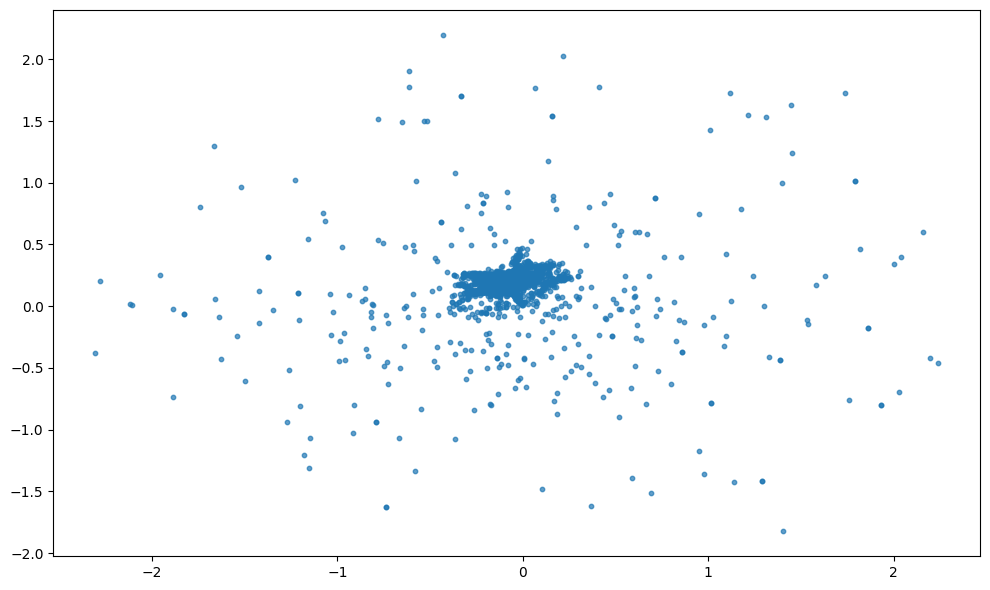

In [95]:
plt.figure(figsize=(10, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, alpha=0.7)
plt.tight_layout()
plt.show()

In [96]:
from l2gv2.example import plot_patches

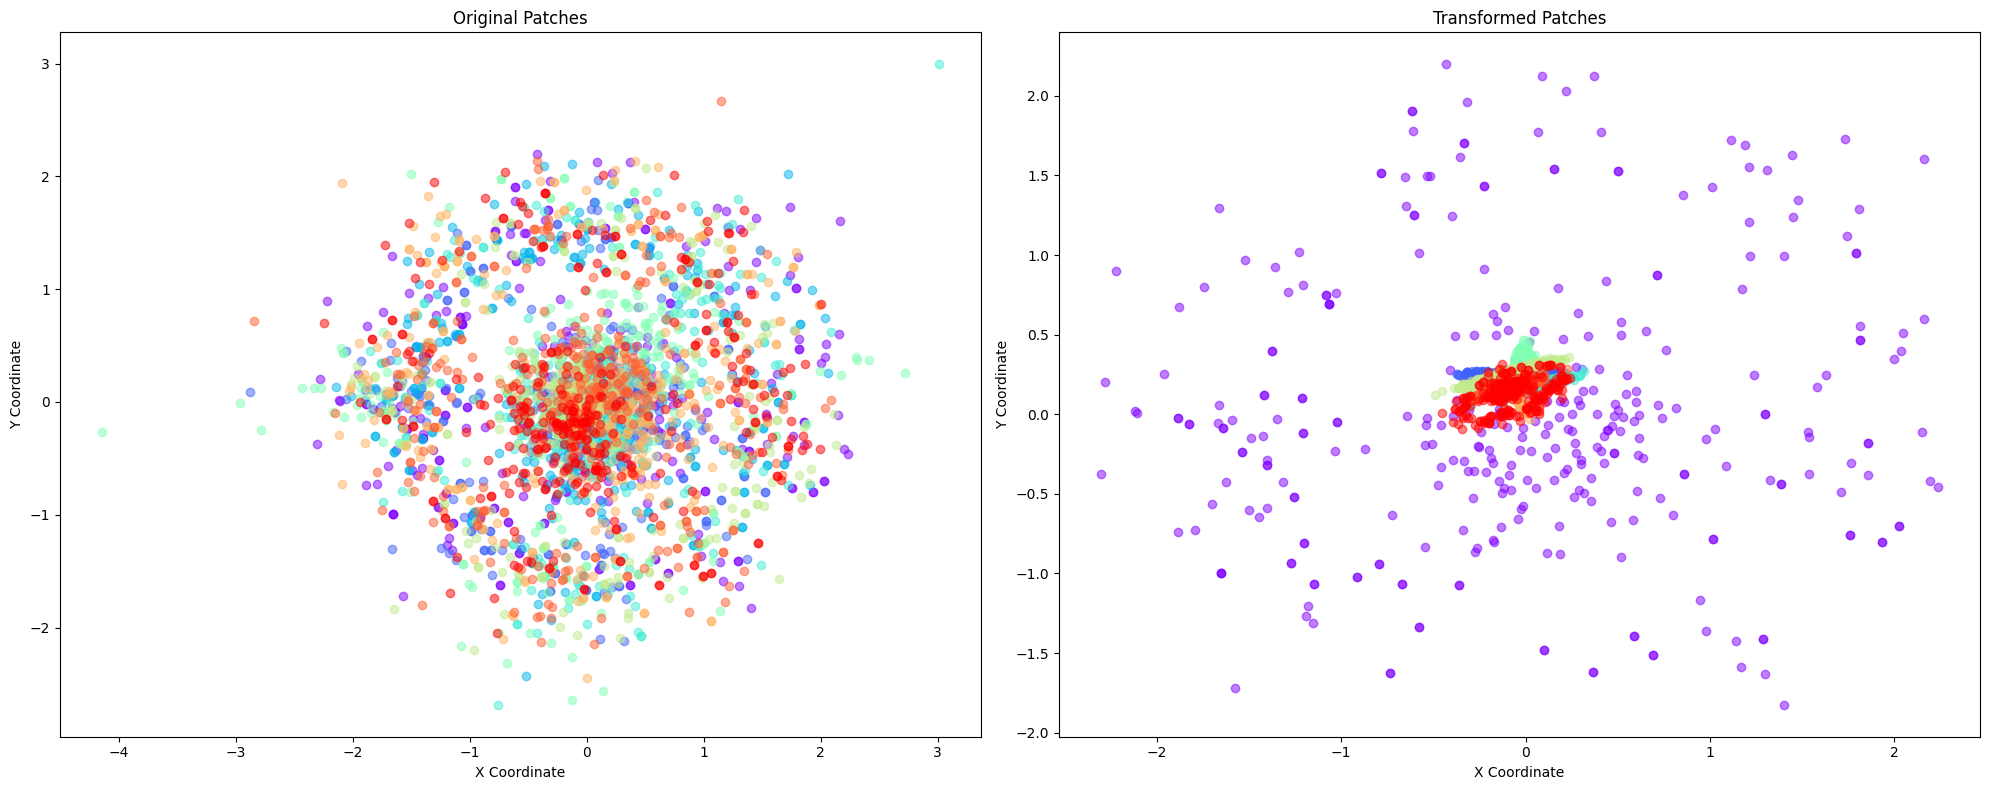

In [97]:
plot_patches(patches, geo_aligner.patches)

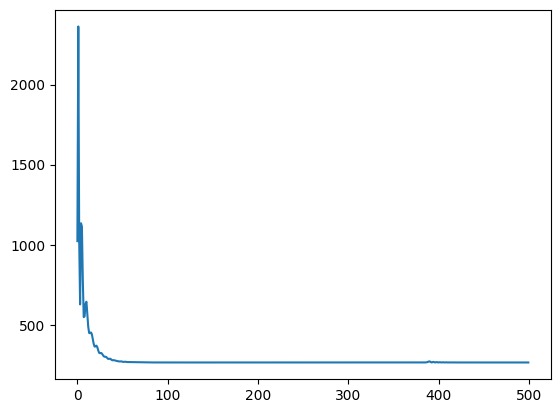

In [98]:
plt.plot(geo_aligner.loss_hist)
plt.show()

In [ ]:
def hierarchical_cluster_and_embed(graph: TGraph, m: int, k: int) -> List[Tuple[nx.Graph, List[float]]]:
    if graph.number_of_nodes() <= m:
        return [(graph, embed(graph))]
    
    clusters = cluster(graph, k)
    results = []
    
    for subgraph in clusters:
        results.extend(hierarchical_cluster_and_embed(subgraph, m, k))
    
    return results